In [2]:
import sys
import os



import numpy as np
from SynthTempNetwork import Individual, SynthTempNetwork
from TemporalNetwork import ContTempNetwork, StaticTempNetwork
from FlowStability import SparseClustering, FlowIntegralClustering, run_multi_louvain, avg_norm_var_information
import parallel_clustering
import pickle

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
import matplotx

from scipy.sparse import (lil_matrix, dok_matrix, diags, eye, isspmatrix_csr, isspmatrix,
                          csr_matrix, coo_matrix, csc_matrix)
from scipy.sparse.linalg import eigsh

from SparseStochMat import sparse_autocov_mat

import auxiliary_functions

Could not load sparse_dot_mkl. Will use scipy.sparse for matrix products.


# Clustering

In [3]:
net_rw = ContTempNetwork.load('/home/b/skoove/Desktop/entropy/paper_data/socio_pat_primary_school/primaryschoolnet',
                              attributes_list=['node_to_label_dict',
                      'events_table',
                      'times',
                      'time_grid',
                      'num_nodes',
                      '_overlapping_events_merged',
                      'start_date',
                      'node_label_array',
                      'male_array',
                      'female_array',
                      'node_first_start_array',
                      'node_last_end_array',
                      'node_class_array',
                      'datetimes'])

In [4]:
lamdas_growing = np.logspace(-5,0,200)

In [5]:
# multi_res_heat = {}
# for lamda in lamdas_growing:
#     with open(f'//scratch/tmp/180/skoove/growing_experiment300_temporal_heat/clustersplot/cluster{lamda:.11f}', 'rb') as f:
#         cluster = pickle.load(f)

#     multi_res_heat[lamda] = cluster
# avg_nclusters_forw_heat = [np.mean([len(c) for c in \
#                    multi_res_heat[lamda] if len(c)>1]) for lamda in lamdas_growing]

# NVI_forw_heat = [avg_norm_var_information(multi_res_heat[lamda]) for lamda in lamdas_growing]

multi_res_rw = {}
for lamda in lamdas_growing:
    with open(f'//scratch/tmp/180/skoove/primaryschoolnet_rw/clustersplot/cluster{lamda:.11f}', 'rb') as f:
        cluster = pickle.load(f)
        
    multi_res_rw[lamda] = cluster
avg_nclusters_forw_rw = [np.mean([len(c) for c in \
                   multi_res_rw[lamda] if len(c)>1]) for lamda in lamdas_growing]

NVI_forw_rw = [avg_norm_var_information(multi_res_rw[lamda]) for lamda in lamdas_growing]

In [6]:
def derivative(v1, v2):
    assert len(v1) == len(v2), "Error: in order to compute the numerical derivative, the two varibales need to have the same lenght."
    derivative = []
    for i, vi in enumerate(v1[1:]):
        m1 =(vi - v1[i-1])/(v2[i]-v2[i-1])
        m2 =(v1[i+1] - vi)/(v2[i+1]-v2[i])
        derivative.append((m1+m2)/2)
    return derivative

In [7]:
lamdas_vNS = np.logspace(-5,0,200)

vNS_heat_end = []
vNS_rw_end = []
for i, lamda in enumerate(lamdas_vNS):
    # with open(f'//scratch/tmp/180/skoove/growing_experiment300_temporal_heat/vNS/vNS{lamda:.11f}', 'rb') as f:
    #     S = pickle.load(f)['vNS']
    #     vNS_heat_end.append(S[list(S.keys())[0]][0])

    with open(f'//scratch/tmp/180/skoove/primaryschoolnet_rw/vNSplot/vNS{lamda:.11f}', 'rb') as f:
        S = pickle.load(f)['vNS']
        vNS_rw_end.append(S[list(S.keys())[0]][0])

In [8]:
S1 = vNS_rw_end
# S2 = vNS_heat_end

between_lamdas_vNS = np.linspace(-5,0,200)
Q1 = derivative(S1, between_lamdas_vNS)
# Q2 = derivative(S2, between_lamdas_vNS)

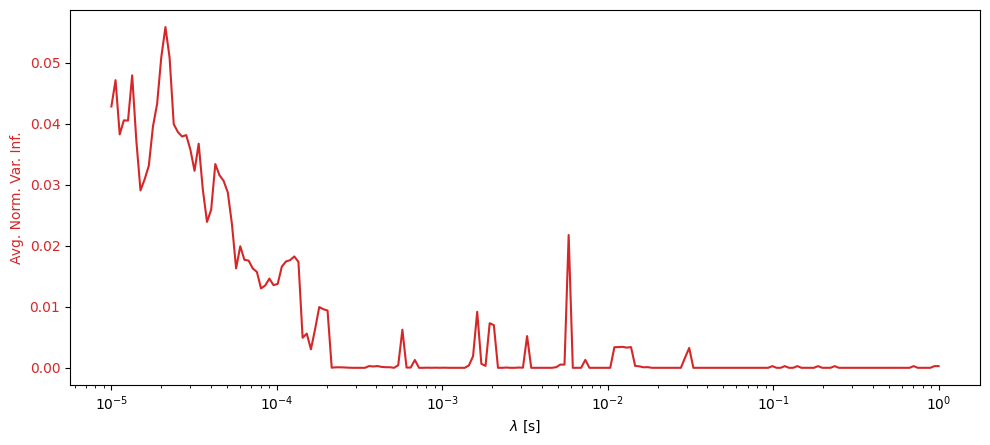

In [9]:
fig, axs = plt.subplots(1,1, sharex=False, figsize=(10, 5))

####### First Plot
color = 'tab:red'
axs.plot(lamdas_growing, NVI_forw_rw, color=color, label='static norm NVI')

axs.set_xscale('log')
axs.set_xlabel(r'$\lambda$ [s]')
axs.set_ylabel('Avg. Norm. Var. Inf.', color=color)
axs.tick_params(axis='y', labelcolor=color)
# axs.text(-0.1,1.1, '(A)', transform=axs.transAxes)

# fig.suptitle("A,B --> rw, C,D --> heat", fontsize=12)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.subplots_adjust(top=0.88) # # Tight layout requires the title to be spaced accordingly

#plt.savefig('/home/b/skoove/Desktop/primary_school/NVI_rw_primaryschool_solo.png', format='png', dpi=300)

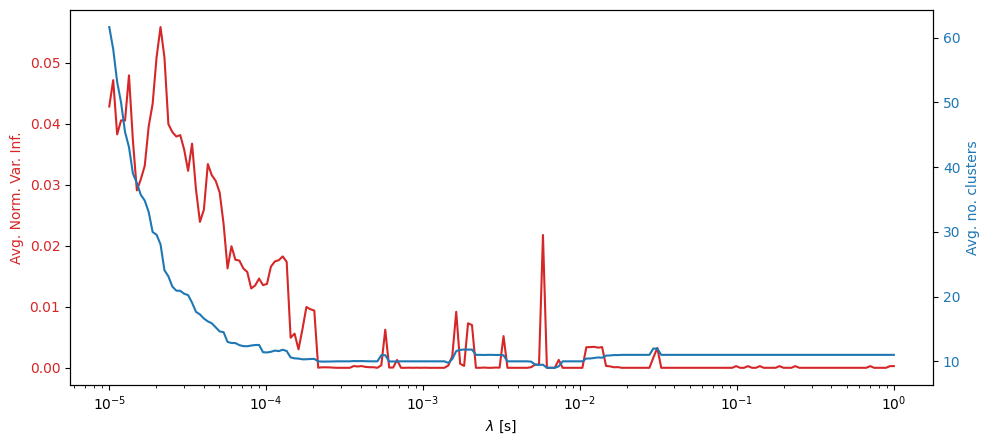

In [10]:
fig, axs = plt.subplots(1,1, sharex=False, figsize=(10, 5))

####### First Plot
color = 'tab:red'
axs.plot(lamdas_growing, NVI_forw_rw, color=color, label='static norm NVI')

axs.set_xscale('log')
axs.set_xlabel(r'$\lambda$ [s]')
axs.set_ylabel('Avg. Norm. Var. Inf.', color=color)
axs.tick_params(axis='y', labelcolor=color)
# axs.text(-0.1,1.1, '(A)', transform=axs.transAxes)

ax1 = axs.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax1.plot(lamdas_growing, avg_nclusters_forw_rw, color=color, label='edge-centric')

ax1.set_xlabel(r'$\lambda$ [s]')
ax1.set_ylabel('Avg. no. clusters', color=color)  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor=color)


# fig.suptitle("A,B --> rw, C,D --> heat", fontsize=12)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.subplots_adjust(top=0.88) # # Tight layout requires the title to be spaced accordingly

#plt.savefig('/home/b/skoove/Desktop/primary_school/NVI_rw_primaryschool_clusters.png', format='png', dpi=300)

/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


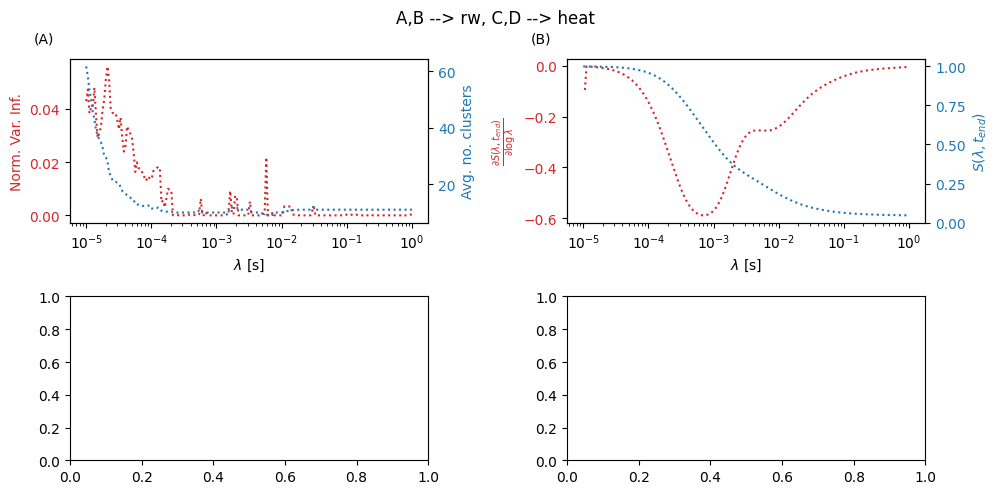

In [11]:
fig, axs = plt.subplots(2,2, sharex=False, figsize=(10, 5))

####### First Plot
color = 'tab:red'
axs[0,0].plot(lamdas_growing, NVI_forw_rw, ':', color=color, label='static norm NVI')

axs[0,0].set_xscale('log')
axs[0,0].set_xlabel(r'$\lambda$ [s]')
axs[0,0].set_ylabel('Norm. Var. Inf.', color=color)
axs[0,0].tick_params(axis='y', labelcolor=color)
axs[0,0].text(-0.1,1.1, '(A)', transform=axs[0,0].transAxes)

ax1 = axs[0,0].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax1.plot(lamdas_growing, avg_nclusters_forw_rw, ':', color=color, label='edge-centric')

ax1.set_xlabel(r'$\lambda$ [s]')
ax1.set_ylabel('Avg. no. clusters', color=color)  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor=color)

####### Second Plot

color = 'tab:red'
axs[0,1].plot(lamdas_vNS[1:], Q1, ':', color=color, label='dvNSdt')

axs[0,1].set_xscale('log')
axs[0,1].set_xlabel(r'$\lambda$ [s]')

axs[0,1].set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
axs[0,1].tick_params(axis='y', labelcolor=color)
axs[0,1].text(-0.1,1.1, '(B)', transform=axs[0,1].transAxes)

ax2 = axs[0,1].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(lamdas_vNS, vNS_rw_end, ':', color=color, label='vNS')

ax2.set_ylabel(r'$S(\lambda, t_{end})$', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)



# ####### Third Plot
# color = 'tab:red'
# axs[1,0].plot(lamdas_growing, NVI_forw_heat, color=color, label='static norm NVI')

# axs[1,0].set_xscale('log')
# axs[1,0].set_xlabel(r'$\lambda$ [s]')
# axs[1,0].set_ylabel('Norm. Var. Inf.', color=color)
# axs[1,0].tick_params(axis='y', labelcolor=color)
# axs[1,0].text(-0.1,1.1, '(C)', transform=axs[1,0].transAxes)

# ax3 = axs[1,0].twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:blue'
# ax3.plot(lamdas_growing, avg_nclusters_forw_heat, color=color, label='edge-centric')

# ax3.set_xlabel(r'$\lambda$ [s]')
# ax3.set_ylabel('Avg. no. clusters', color=color)  # we already handled the x-label with ax1
# ax3.tick_params(axis='y', labelcolor=color)

# ####### Fourth Plot

# color = 'tab:red'
# axs[1,1].plot(lamdas_vNS[1:], Q1, color=color, label='dvNSdt')

# axs[1,1].set_xscale('log')
# axs[1,1].set_xlabel(r'$\lambda$ [s]')

# axs[1,1].set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
# axs[1,1].tick_params(axis='y', labelcolor=color)
# axs[1,1].text(-0.1,1.1, '(D)', transform=axs[1,1].transAxes)

# ax4 = axs[1,1].twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:blue'
# ax4.plot(lamdas_vNS, vNS_heat_end, color=color, label='vNS')

# ax4.set_ylabel(r'$S(\lambda, t_{end})$', color=color)  # we already handled the x-label with ax1
# ax4.tick_params(axis='y', labelcolor=color)

fig.suptitle("A,B --> rw, C,D --> heat", fontsize=12)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.subplots_adjust(top=0.88) # # Tight layout requires the title to be spaced accordingly

#plt.savefig('/home/b/skoove/Desktop/primary_school/clustering_vNS_rw_primaryschool.png', format='png', dpi=300)

## Extended Plot Day 1

In [12]:
lamdas_extended = np.logspace(-7,0,180)
multi_res_rw = {}
for lamda in lamdas_extended:
    with open(f'//scratch/tmp/180/skoove/primaryschoolnet_rw/clustersplot_extended0_1556/cluster{lamda:.11f}', 'rb') as f:
        cluster = pickle.load(f)
        
    multi_res_rw[lamda] = cluster
avg_nclusters_forw_rw = [np.mean([len(c) for c in \
                   multi_res_rw[lamda] if len(c)>1]) for lamda in lamdas_extended]

NVI_forw_rw = [avg_norm_var_information(multi_res_rw[lamda]) for lamda in lamdas_extended]

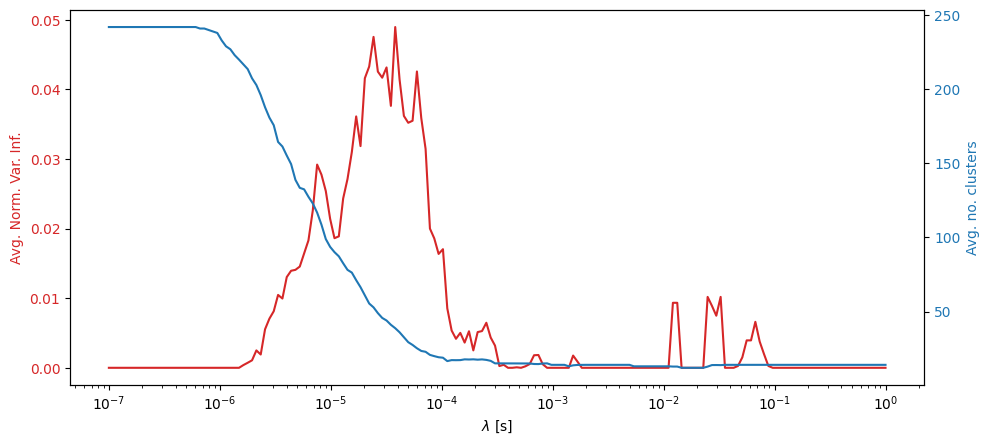

In [13]:
fig, axs = plt.subplots(1,1, sharex=False, figsize=(10, 5))

####### First Plot
color = 'tab:red'
axs.plot(lamdas_extended, NVI_forw_rw, color=color, label='static norm NVI')

axs.set_xscale('log')
axs.set_xlabel(r'$\lambda$ [s]')
axs.set_ylabel('Avg. Norm. Var. Inf.', color=color)
axs.tick_params(axis='y', labelcolor=color)
# axs.text(-0.1,1.1, '(A)', transform=axs.transAxes)

ax1 = axs.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax1.plot(lamdas_extended, avg_nclusters_forw_rw, color=color, label='edge-centric')

ax1.set_xlabel(r'$\lambda$ [s]')
ax1.set_ylabel('Avg. no. clusters', color=color)  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor=color)


# fig.suptitle("A,B --> rw, C,D --> heat", fontsize=12)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.subplots_adjust(top=0.88) # # Tight layout requires the title to be spaced accordingly

#plt.savefig('/home/b/skoove/Desktop/primary_school/NVI_rw_primaryschool_clusters.png', format='png', dpi=300)

In [ ]:
avg_nclusters_forw_rw[100:130]

## Backward


In [ ]:
multi_res_bw_rw = {}
for lamda in lamdas_extended:
    with open(f'//scratch/tmp/180/skoove/primaryschoolnet_rw/clustersplot_extended_bw0_1556/cluster{lamda:.11f}', 'rb') as f:
        cluster = pickle.load(f)
        
    multi_res_bw_rw[lamda] = cluster
avg_nclusters_bw_rw = [np.mean([len(c) for c in \
                   multi_res_bw_rw[lamda] if len(c)>1]) for lamda in lamdas_extended]

NVI_bw_rw = [avg_norm_var_information(multi_res_bw_rw[lamda]) for lamda in lamdas_extended]

In [ ]:
fig, axs = plt.subplots(1,1, sharex=False, figsize=(10, 5))

####### First Plot
color = 'tab:red'
axs.plot(lamdas_extended, NVI_bw_rw, color=color, label='static norm NVI')

axs.set_xscale('log')
axs.set_xlabel(r'$\lambda$ [s]')
axs.set_ylabel('Avg. Norm. Var. Inf.', color=color)
axs.tick_params(axis='y', labelcolor=color)
# axs.text(-0.1,1.1, '(A)', transform=axs.transAxes)

ax1 = axs.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax1.plot(lamdas_extended, avg_nclusters_bw_rw, color=color, label='edge-centric')

ax1.set_xlabel(r'$\lambda$ [s]')
ax1.set_ylabel('Avg. no. clusters', color=color)  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor=color)


# fig.suptitle("A,B --> rw, C,D --> heat", fontsize=12)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.subplots_adjust(top=0.88) # # Tight layout requires the title to be spaced accordingly

#plt.savefig('/home/b/skoove/Desktop/primary_school/NVI_bw_rw_primaryschool_clusters.png', format='png', dpi=300)

## Alluvial Diagram Forward-Backward day 1

In [ ]:
# bestcluster0 = multi_res_rw[lamdas_extended[76]][0]
# bestcluster1 = multi_res_bw_rw[lamdas_extended[150]][10]


# #%% make data for flow diagram

# source_comms = bestcluster0
# target_comms = bestcluster1
# class_dict = {clas : set(net_rw.node_array[net_rw.node_class_array == clas]) for \
#                   clas in np.unique(net_rw.node_class_array)}

# flows = []
# for clas, clas_set in class_dict.items():
#     for s, comm_s in enumerate(source_comms):
#         for t, comm_t in enumerate(target_comms):
#             val = len(clas_set.intersection(comm_s).intersection(comm_t))
#             if val > 0:
#                 flows.append({'source': s, 'target': t, 'type': clas, 'value': val})

# df_flows = pd.DataFrame.from_dict(flows)

In [ ]:
# df_flows['target_label'] = df_flows['target'] + int(np.max(df_flows['source']) + 1)

In [ ]:
# import plotly.graph_objects as go

# list_value = df_flows['value'].copy()
# list_value[df_flows['value'] == 1] = 1

# data = {
#     'source': list(df_flows['source']),
#     'target': list(df_flows['target_label']),
#     'value': list_value
# }

# # Create DataFrame
# df = pd.DataFrame(data)

# # Define a mapping of old labels to new labels
# label_mapping = {}
# for i in range(df_flows.shape[0]):
#     label_mapping[df_flows['source'][i]] = df_flows['source'][i]
#     label_mapping[df_flows['target_label'][i]] = df_flows['target'][i]

# # Create lists of unique source and target labels
# all_nodes = list(pd.concat([df_flows['source'], df_flows['target_label']]).unique())

# # Apply the label mapping to the node list
# all_nodes_renamed = [label_mapping[node] for node in all_nodes]

# # Create mapping of nodes to indices
# node_map = {node: idx for idx, node in enumerate(all_nodes)}

# # Map source and target nodes to their indices
# df['source_id'] = df['source'].map(node_map)
# df['target_id'] = df['target'].map(node_map)

# # Define colors for each link
# color_list =["#4ba706",
# "#a2007e",
# "#806dcb",
# "#5eb275",
# "#ca3b01",
# "#01a4d6",
# "#b77600",
# "#a39643",
# "#cc6ea9",
# "#1e5e39",
# "#cb5b5a"]

# dict_color = {}
# for i, df_type in enumerate(df_flows['type'].unique()):
#     dict_color[df_type] = color_list[i]


# link_color = [dict_color[i] for i in df_flows['type']]

# # Create the Sankey diagram
# sankey=go.Sankey(
#     node=dict(
#         pad=10,
#         thickness=10,
#         line=dict(color="black", width=0.5),
#         #label=all_nodes_renamed 
#     ),
#     link=dict(
#         source=df['source_id'],
#         target=df['target_id'],
#         value=df['value'],
#         color=link_color,
#         customdata=df_flows['type'],
#         #hovertemplate='Source: %{source.label}<br>Target: %{target.label}<br>Value: %{value}<br>Label: %{customdata}<extra></extra>'
#         hovertemplate='Value: %{value}<br> %{customdata}<extra></extra>'
#     )
# )

# # Create dummy scatter traces for the legend

# seen = set()
# unique_link_color = [x for x in link_color if not (x in seen or seen.add(x))]

# legend_entries = []
# for color, label in zip(unique_link_color, df_flows['type'].unique()):
#     legend_entries.append(go.Scatter(
#         x=[None],
#         y=[None],
#         mode='markers',
#         marker=dict(size=8, color=color),
#         legendgroup=label,
#         showlegend=True,
#         name=label
#     ))

# # Combine Sankey diagram and legend entries
# fig = go.Figure(data=[sankey] + legend_entries)

# fig.update_layout(
#     #title_text="Sankey Diagram with Custom Legend",
#     font_size=10,
#     xaxis=dict(visible=False),
#     yaxis=dict(visible=False),
#     plot_bgcolor='rgba(255,255,255,1)',
#     paper_bgcolor='rgba(255,255,255,1)',
#     showlegend=True,
#     legend=dict(
#         font=dict(size=14),  # Adjust the font size of the legend
#         itemwidth=30,        # Adjust the width of the legend items
#         itemsizing='constant',
#         traceorder='normal',
#         orientation='v',     # Arrange legend items vertically
#         yanchor='middle',
#         y=0.5,               # Position legend at the middle height
#         xanchor='left',
#         x=-0.15              # Position legend to the left of the plot
#     ),
#     margin=dict(l=100, r=10, t=10, b=10)  # Increase left margin for legend
# )

# fig.show()

# Day 1

In [ ]:
multi_res_rw = {}
for lamda in lamdas_growing:
    with open(f'//scratch/tmp/180/skoove/primaryschoolnet_rw/clustersplot0_1556/cluster{lamda:.11f}', 'rb') as f:
        cluster = pickle.load(f)
        
    multi_res_rw[lamda] = cluster
avg_nclusters_forw_rw = [np.mean([len(c) for c in \
                   multi_res_rw[lamda] if len(c)>1]) for lamda in lamdas_growing]

NVI_forw_rw = [avg_norm_var_information(multi_res_rw[lamda]) for lamda in lamdas_growing]

In [ ]:
fig, axs = plt.subplots(1,1, sharex=False, figsize=(10, 5))

####### First Plot
color = 'tab:red'
axs.plot(lamdas_growing, NVI_forw_rw, color=color, label='static norm NVI')

axs.set_xscale('log')
axs.set_xlabel(r'$\lambda$ [s]')
axs.set_ylabel('Avg. Norm. Var. Inf.', color=color)
axs.tick_params(axis='y', labelcolor=color)
# axs.text(-0.1,1.1, '(A)', transform=axs.transAxes)

# fig.suptitle("A,B --> rw, C,D --> heat", fontsize=12)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.subplots_adjust(top=0.88) # # Tight layout requires the title to be spaced accordingly

#plt.savefig('/home/b/skoove/Desktop/primary_school/NVI_rw_primaryschool_solo_day1.png', format='png', dpi=300)

In [ ]:
fig, axs = plt.subplots(1,1, sharex=False, figsize=(10, 5))

####### First Plot
color = 'tab:red'
axs.plot(lamdas_growing, NVI_forw_rw, color=color, label='static norm NVI')

axs.set_xscale('log')
axs.set_xlabel(r'$\lambda$ [s]')
axs.set_ylabel('Avg. Norm. Var. Inf.', color=color)
axs.tick_params(axis='y', labelcolor=color)
# axs.text(-0.1,1.1, '(A)', transform=axs.transAxes)

ax1 = axs.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax1.plot(lamdas_growing, avg_nclusters_forw_rw, color=color, label='edge-centric')

ax1.set_xlabel(r'$\lambda$ [s]')
ax1.set_ylabel('Avg. no. clusters', color=color)  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor=color)


# fig.suptitle("A,B --> rw, C,D --> heat", fontsize=12)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.subplots_adjust(top=0.88) # # Tight layout requires the title to be spaced accordingly

#plt.savefig('/home/b/skoove/Desktop/primary_school/NVI_rw_primaryschool_clusters_day1.png', format='png', dpi=300)

# Alluvial Diagram

In [ ]:
print(lamdas_growing[80])
print(lamdas_growing[160])

In [ ]:
# bestcluster0 = multi_res_rw[lamdas_growing[80]][0]
# bestcluster1 = multi_res_rw[lamdas_growing[160]][0]


# #%% make data for flow diagram

# source_comms = bestcluster0
# target_comms = bestcluster1
# class_dict = {clas : set(net_rw.node_array[net_rw.node_class_array == clas]) for \
#                   clas in np.unique(net_rw.node_class_array)}

# flows = []
# for clas, clas_set in class_dict.items():
#     for s, comm_s in enumerate(source_comms):
#         for t, comm_t in enumerate(target_comms):
#             val = len(clas_set.intersection(comm_s).intersection(comm_t))
#             if val > 0:
#                 flows.append({'source': s, 'target': t, 'type': clas, 'value': val})

# df_flows = pd.DataFrame.from_dict(flows)

In [ ]:
# df_flows['target_label'] = df_flows['target'] + int(np.max(df_flows['source']) + 1)

In [ ]:
# import plotly.graph_objects as go

# # Sample data
# data = {
#     'source': list(df_flows['source']),
#     'target': list(df_flows['target_label']),
#     'value': list(df_flows['value'])
# }

# # Create DataFrame
# df = pd.DataFrame(data)

# # Define a mapping of old labels to new labels
# label_mapping = {}
# for i in range(df_flows.shape[0]):
#     label_mapping[df_flows['source'][i]] = df_flows['source'][i]
#     label_mapping[df_flows['target_label'][i]] = df_flows['target'][i]

# # Create lists of unique source and target labels
# all_nodes = list(pd.concat([df_flows['source'], df_flows['target_label']]).unique())

# # Apply the label mapping to the node list
# all_nodes_renamed = [label_mapping[node] for node in all_nodes]

# # Create mapping of nodes to indices
# node_map = {node: idx for idx, node in enumerate(all_nodes)}

# # Map source and target nodes to their indices
# df['source_id'] = df['source'].map(node_map)
# df['target_id'] = df['target'].map(node_map)

# # Define colors for each link
# color_list =["#4ba706",
# "#a2007e",
# "#806dcb",
# "#5eb275",
# "#ca3b01",
# "#01a4d6",
# "#b77600",
# "#a39643",
# "#cc6ea9",
# "#1e5e39",
# "#cb5b5a"]

# dict_color = {}
# for i, df_type in enumerate(df_flows['type'].unique()):
#     dict_color[df_type] = color_list[i]


# link_color = [dict_color[i] for i in df_flows['type']]

# # Create the Sankey diagram
# sankey=go.Sankey(
#     node=dict(
#         pad=10,
#         thickness=1,
#         line=dict(color="black", width=0.5),
#         #label=all_nodes_renamed 
#     ),
#     link=dict(
#         source=df['source_id'],
#         target=df['target_id'],
#         value=df['value'],
#         color=link_color,
#         customdata=df_flows['type'],
#         #hovertemplate='Source: %{source.label}<br>Target: %{target.label}<br>Value: %{value}<br>Label: %{customdata}<extra></extra>'
#         hovertemplate='Value: %{value}<br> %{customdata}<extra></extra>'
#     )
# )

# # Create dummy scatter traces for the legend

# seen = set()
# unique_link_color = [x for x in link_color if not (x in seen or seen.add(x))]

# legend_entries = []
# for color, label in zip(unique_link_color, df_flows['type'].unique()):
#     legend_entries.append(go.Scatter(
#         x=[None],
#         y=[None],
#         mode='markers',
#         marker=dict(size=8, color=color),
#         legendgroup=label,
#         showlegend=True,
#         name=label
#     ))

# # Combine Sankey diagram and legend entries
# fig = go.Figure(data=[sankey] + legend_entries)

# fig.update_layout(
#     #title_text="Sankey Diagram with Custom Legend",
#     font_size=10,
#     xaxis=dict(visible=False),
#     yaxis=dict(visible=False),
#     plot_bgcolor='rgba(255,255,255,1)',
#     paper_bgcolor='rgba(255,255,255,1)',
#     showlegend=True,
#     legend=dict(
#         font=dict(size=10),  # Adjust the font size of the legend
#         itemwidth=30,        # Adjust the width of the legend items
#         itemsizing='constant',
#         traceorder='normal',
#         orientation='h',     # Arrange legend items horizontally
#         yanchor='bottom',
#         y=-0.2,              # Position legend below the plot
#         xanchor='center',
#         x=0.5
#     ),
#     margin=dict(l=10, r=10, t=50, b=50)  # Adjust margins to fit the legend
# )

# fig.show()

# VNS Plot

In [15]:
selected_lamdas = np.logspace(-5,0,10)
sample_times = list(np.arange(0, len(net_rw.times), 10))

In [ ]:
vNS_selected = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/primaryschoolnet_rw/vNSselected/vNS{lamda:.11f}', 'rb') as f:
        S = pickle.load(f)
        vNS_selected.append(S['vNS'][f'{lamda:.11f}']) #(S[list(S.keys())[0]][0])

In [34]:
net_times_hours = net_rw.times[sample_times] / 3600
list_hours_day1 = range(9,18)
list_hours_day2 = range(33,42)

In [ ]:
print(net_times_hours)
print(np.argmax(net_times_hours > 18))
print(net_times_hours[156])
print(net_times_hours[155])

In [ ]:
# Create a 2x3 grid of subplots with specific figure size
fig = plt.figure(figsize=(12, 4))
gs = GridSpec(1, 3, width_ratios=[1, 1, 1], hspace=0.3, wspace=0.55)


####### Third Plot
color = 'tab:red'
axsc = plt.subplot(gs[0,0])
axsc.plot(lamdas_growing, NVI_forw_rw, color=color)

axsc.set_xscale('log')
axsc.set_xlabel(r'$\lambda$ [s]')
axsc.set_ylabel('Norm. Var. Inf.', color=color)
axsc.tick_params(axis='y', labelcolor=color)
axsc.text(-0.1,1.05, '(A)', transform=axsc.transAxes)

ax3 = axsc.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax3.plot(lamdas_growing, avg_nclusters_forw_rw, '--', color=color)

ax3.set_xlabel(r'$\lambda$ [s]')
ax3.set_ylabel('Avg. no. clusters', color=color)  # we already handled the x-label with ax1
ax3.tick_params(axis='y', labelcolor=color)

####### Fourth Plot

color = 'tab:red'
axsd = plt.subplot(gs[0,1])
axsd.plot(lamdas_vNS[1:], Q1, color=color, label='dvNSdt')

axsd.set_xscale('log')
axsd.set_xlabel(r'$\lambda$ [s]')

axsd.set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
axsd.tick_params(axis='y', labelcolor=color)
axsd.text(-0.1,1.05, '(B)', transform=axsd.transAxes)

min_ds7dt = np.min(Q1)
max_ds7dt = np.max(Q1)
list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']
axsd.vlines(x = selected_lamdas,
            ymin = [min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt],
            ymax = [max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt],
            colors= list_colors, linestyles='dotted')

ax4 = axsd.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax4.plot(lamdas_vNS, vNS_rw_end, '--', color=color, label='vNS')

ax4.set_ylabel(r'$S(\lambda, t_{end})$', color=color)  # we already handled the x-label with ax1
ax4.tick_params(axis='y', labelcolor=color)


#Plot 5
list_annotate_y = []
for i, lamda in enumerate(selected_lamdas):
    list_annotate_y.append(np.mean(vNS_selected[i]))

shift_annotate_y = [0.01, 0.03, 0.02, -0.05, -0.4, -0.35, -0.05, -0.05, -0.06]

axse = plt.subplot(gs[0,2])
for i, lamda in enumerate(selected_lamdas):
    #axse.plot(net_heat.times[sample_times], vNS_heat0_50[i], label=r'log$(\lambda) = $' + f'{np.linspace(-2.5,0,9)[i]}')
    exponent = f'{np.linspace(-3,1,10)[i]}' #"{:.2e}".format(selected_lamdas[i]) #f'{np.linspace(-2.5,0,9)[i]}'
    axse.plot(net_rw.times[sample_times] / 3600, vNS_selected[i], color = list_colors[i], label=r'$\lambda = 10^{%s} $' % exponent)
    axse.set_xlabel('t [h]')
    #axse.annotate(text = r'$\lambda = e^{%s}$' % exponent, xy=[100, list_annotate_y[i]], xytext=[105, list_annotate_y[i]+shift_annotate_y[1]-0.05], color='magenta')
axse.text(-0.1,1.05, '(C)', transform=axse.transAxes)
axse.set_ylabel('$S(t)$')
matplotx.line_labels()
#axse.legend(fontsize='small', loc='upper left', bbox_to_anchor=(1.05, 1))


#deltat1 = 300 / 3
#plt.xticks([0, deltat1, 2*deltat1, 3*deltat1,],[0, str(deltat1), str(2*deltat1), str(3*deltat1)])


fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig('/home/b/skoove/Desktop/primary_school/vNS.png', format='png', dpi=300)
plt.show()

NameError: name 'vNS_selected' is not defined

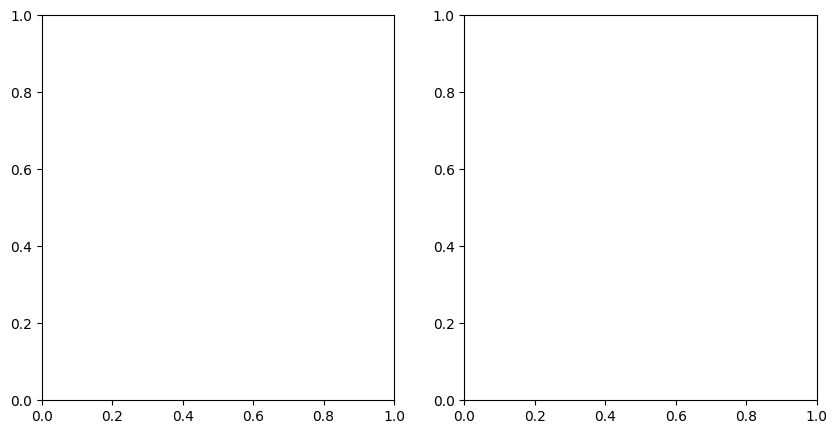

In [35]:
fig, axs = plt.subplots(1,2, sharex=False, figsize=(10, 5))

list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']
times_hours_day1 = net_times_hours[0:156]
times_hours_day2 = net_times_hours[156:]

####### Fourth Plot

for i, lamda in enumerate(selected_lamdas):
    axs[0].plot(times_hours_day1, vNS_selected[i][0:156], color = list_colors[i], label='lamda = ' + f'{lamda:.11f}')


axs[0].set_xlabel('t')
color = 'tab:red'
axs[0].set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
axs[0].tick_params(axis='y', labelcolor=color)
axs[0].text(-0.1,1.1, '(D)', transform=axs[0].transAxes)

list_hours = range(9,18)
ymin = np.min(vNS_selected)
ymax = np.max(vNS_selected)

axs[0].vlines(x = list_hours_day1,
            ymin = ymin,
            ymax = ymax,
            linestyles='dotted')


#Plot 5

for i, lamda in enumerate(selected_lamdas):
    axs[1].plot(times_hours_day2, vNS_selected[i][156:], color = list_colors[i], label='lamda = ' + f'{lamda:.11f}')


axs[1].set_xlabel('t')
color = 'tab:red'
axs[1].set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
axs[1].tick_params(axis='y', labelcolor=color)
#axs[1].text(-0.1,1.1, '(E)', transform=axs[1].transAxes)

list_hours = range(9,18)
ymin = np.min(vNS_selected)
ymax = np.max(vNS_selected)

axs[1].vlines(x = list_hours_day2,
            ymin = ymin,
            ymax = ymax,
            linestyles='dotted')

#plt.savefig('/home/b/skoove/Desktop/primary_school/vNS_d1d2.png', format='png', dpi=300)
plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))

fig.suptitle("vNS: Day 1 and Day 2", fontsize=12)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.subplots_adjust(top=0.88) # # Tight layout requires the title to be spaced accordingly

plt.show()

In [ ]:
vNS_selected_hr = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/primaryschoolnet_rw/vNSselected_hr/vNS{lamda:.11f}', 'rb') as f:
        S = pickle.load(f)
        vNS_selected_hr.append(S['vNS'][f'{lamda:.11f}']) #(S[list(S.keys())[0]][0])

sample_times_hr= list(np.arange(0, len(net_rw.times)-2))

In [ ]:
net_times_hours_hr = net_rw.times[sample_times_hr] / 3600
list_hours_day1 = range(9,18)
list_hours_day2 = range(33,42)

In [ ]:
print(net_times_hours_hr)
print(np.argmax(net_times_hours_hr > 18))
print(net_times_hours_hr[1556])
print(net_times_hours_hr[1555])

In [ ]:
fig, axs = plt.subplots(1,2, sharex=False, figsize=(10, 5))

list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']
times_hours_day1 = net_times_hours_hr[0:1556]
times_hours_day2 = net_times_hours_hr[1556:]

####### Fourth Plot

for i, lamda in enumerate(selected_lamdas):
    axs[0].plot(times_hours_day1, vNS_selected_hr[i][0:1556], color = list_colors[i], label='lamda = ' + f'{lamda:.11f}')


axs[0].set_xlabel('t')
color = 'tab:red'
axs[0].set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
axs[0].tick_params(axis='y', labelcolor=color)
axs[0].text(-0.1,1.1, '(D)', transform=axs[0].transAxes)

list_hours = range(9,18)
ymin = np.min(vNS_selected_hr)
ymax = np.max(vNS_selected_hr)

axs[0].vlines(x = list_hours_day1,
            ymin = ymin,
            ymax = ymax,
            linestyles='dotted')


#Plot 5

for i, lamda in enumerate(selected_lamdas):
    axs[1].plot(times_hours_day2, vNS_selected_hr[i][1556:], color = list_colors[i], label='lamda = ' + f'{lamda:.11f}')


axs[1].set_xlabel('t')
color = 'tab:red'
axs[1].set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
axs[1].tick_params(axis='y', labelcolor=color)
#axs[1].text(-0.1,1.1, '(E)', transform=axs[1].transAxes)

list_hours = range(9,18)
ymin = np.min(vNS_selected_hr)
ymax = np.max(vNS_selected_hr)

axs[1].vlines(x = list_hours_day2,
            ymin = ymin,
            ymax = ymax,
            linestyles='dotted')

#plt.savefig('/home/b/skoove/Desktop/primary_school/vNS_d1d2.png', format='png', dpi=300)
plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))

fig.suptitle("vNS_hr: Day 1 and Day 2", fontsize=12)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.subplots_adjust(top=0.88) # # Tight layout requires the title to be spaced accordingly

plt.show()

# Condtitional S

In [16]:
Conditional_S_selected = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/primaryschoolnet_rw/conditional_S_selected/S_rate{lamda:.11f}', 'rb') as f:
        S_rate = pickle.load(f)
        Conditional_S_selected.append(S_rate['S_rate'][f'{lamda:.11f}'])

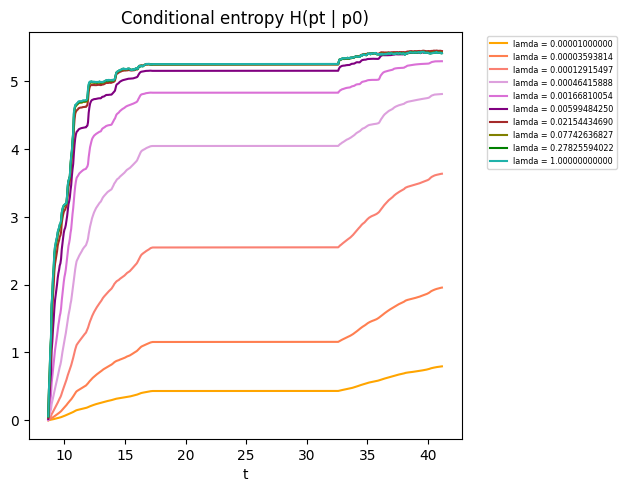

In [17]:
#Plot 5
list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']

for i, lamda in enumerate(selected_lamdas):
    plt.plot(net_rw.times[sample_times]/3600, Conditional_S_selected[i], color = list_colors[i], label='lamda = ' + f'{lamda:.11f}')
    plt.xlabel('t')


plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))
plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Conditional entropy H(pt | p0)')
#plt.savefig('/home/b/skoove/Desktop/primary_school/conditionalH.png', format='png', dpi=300)
plt.show()

In [18]:
Conditional_S_selected_hr = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/primaryschoolnet_rw/conditional_S_selected_hr/S_rate{lamda:.11f}', 'rb') as f:
        S_rate = pickle.load(f)
        Conditional_S_selected_hr.append(S_rate['S_rate'][f'{lamda:.11f}']) #(S[list(S.keys))[0]][0])

NameError: name 'net_times_hours_hr' is not defined

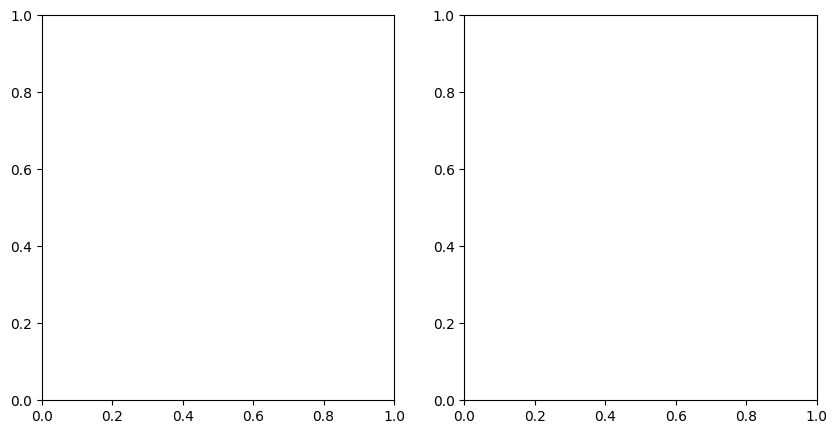

In [19]:
fig, axs = plt.subplots(1,2, sharex=False, figsize=(10, 5))

list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']
times_hours_day1 = net_times_hours_hr[0:1556]
times_hours_day2 = net_times_hours_hr[1556:]

####### Fourth Plot

for i, lamda in enumerate(selected_lamdas):
    axs[0].plot(times_hours_day1, Conditional_S_selected_hr[i][0:1556], color = list_colors[i], label='lamda = ' + f'{lamda:.11f}')


axs[0].set_xlabel('t')
axs[0].set_ylabel('Sh')
axs[0].tick_params(axis='y')

list_hours = range(9,18)
ymin = np.min(Conditional_S_selected_hr)
ymax = np.max(Conditional_S_selected_hr)

axs[0].vlines(x = list_hours_day1,
            ymin = ymin,
            ymax = ymax,
            linestyles='dotted')


#Plot 5

for i, lamda in enumerate(selected_lamdas):
    axs[1].plot(times_hours_day2, Conditional_S_selected_hr[i][1556:], color = list_colors[i], label='lamda = ' + f'{lamda:.11f}')


axs[1].set_xlabel('t')

axs[1].set_ylabel('Sh')
axs[1].tick_params(axis='y')
#axs[1].text(-0.1,1.1, '(E)', transform=axs[1].transAxes)

list_hours = range(9,18)
ymin = np.min(Conditional_S_selected_hr)
ymax = np.max(Conditional_S_selected_hr)

axs[1].vlines(x = list_hours_day2,
            ymin = ymin,
            ymax = ymax,
            linestyles='dotted')

plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))

fig.suptitle("Conditional Entropy H(pt | p0)_hr: Day 1 and Day 2", fontsize=12)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.subplots_adjust(top=0.88) # # Tight layout requires the title to be spaced accordingly
#plt.savefig('/home/b/skoove/Desktop/primary_school/vNS_d1d2.png', format='png', dpi=300)

plt.show()

# Day 1

In [ ]:
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

NameError: name 'net_times_hours_hr' is not defined

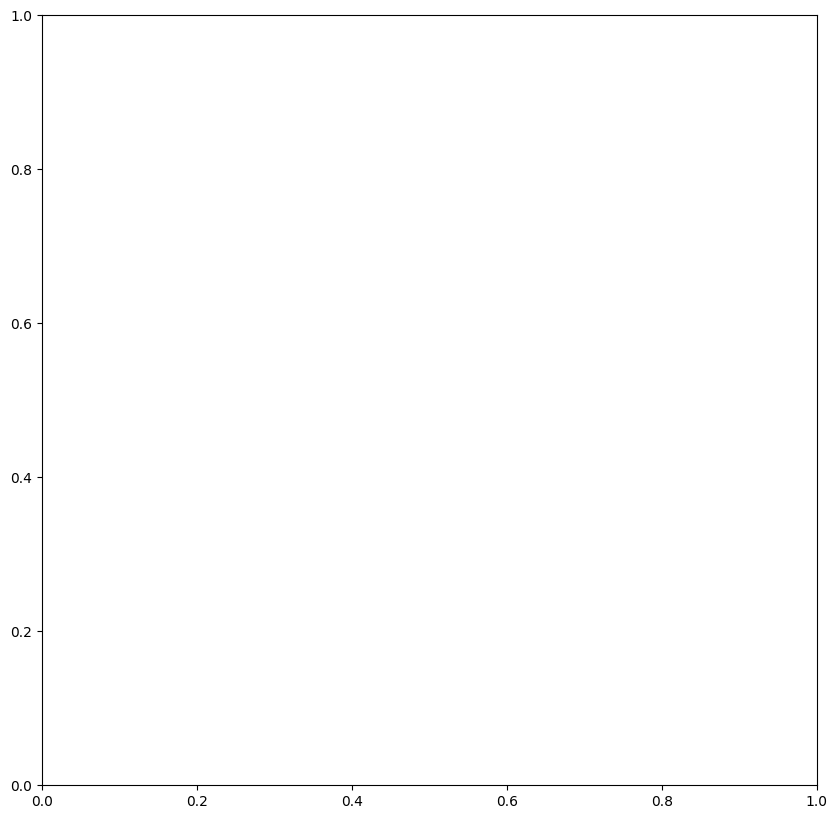

In [20]:
fig, axs = plt.subplots(1,1, sharex=False, figsize=(10, 10))

list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']
times_hours_day1 = net_times_hours_hr[0:1556]

####### Fourth Plot

for i, lamda in enumerate(selected_lamdas):
    axs.plot(times_hours_day1, Conditional_S_selected_hr[i][0:1556], color = list_colors[i], label= r'$\log(\lambda) =$' + f'{np.log10(lamda):.5f}')


#x-axis
axs.set_xlabel('t', fontsize=14)
tick_positions = [10, 12, 14, 16]
tick_labels = ['10 a.m.', '12 p.m.', '2 p.m.', '4 p.m.']
plt.xticks(tick_positions, tick_labels)
#y-axis
#axs.set_ylabel('Sh')
axs.tick_params(axis='y')

list_hours = range(9,18)
ymin = np.min(Conditional_S_selected_hr)
ymax = np.max(Conditional_S_selected_hr)


#plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))

fig.suptitle("Conditional Entropy: Day 1", fontsize=20)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#fig.subplots_adjust(top=0.88) # # Tight layout requires the title to be spaced accordingly
#plt.savefig('/home/b/skoove/Desktop/primary_school/ConditionalH_d1.png', format='png', dpi=600)

plt.show()

In [ ]:
fig, axs = plt.subplots(1,1, sharex=False, figsize=(10, 10))

list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']
times_hours_day1 = net_times_hours_hr[0:1556]

####### Fourth Plot

for i, lamda in enumerate(selected_lamdas):
    axs.plot(times_hours_day1, Conditional_S_selected_hr[i][0:1556], color = list_colors[i], label= r'$\log(\lambda) =$' + f'{np.log10(lamda):.5f}')



#x-axis
axs.set_xlabel('t', fontsize = 14)
tick_positions = [10, 12, 14, 16]
tick_labels = ['10 a.m.', '12 p.m.', '2 p.m.', '4 p.m.']
plt.xticks(tick_positions, tick_labels)
#y-axis
#axs.set_ylabel('Sh')
axs.tick_params(axis='y')

list_hours_day1 = range(10,18,2)
ymin = np.min(Conditional_S_selected_hr[0][0:1556])
ymax = np.max(Conditional_S_selected_hr[-1][0:1556])

axs.vlines(x = list_hours_day1,
            ymin = ymin,
            ymax = ymax,
            linestyles='dotted')



#plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))

fig.suptitle("Conditional Entropy: Day 1", fontsize=20)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#fig.subplots_adjust(top=0.88) # # Tight layout requires the title to be spaced accordingly
#plt.savefig('/home/b/skoove/Desktop/primary_school/ConditionalH_d1_vlines.png', format='png', dpi=600)

plt.show()

# Entropy Rate

In [21]:
S_rate_selected = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/primaryschoolnet_rw/S_rate_selected/S_rate{lamda:.11f}', 'rb') as f:
        S_rate = pickle.load(f)
        S_rate_selected.append(S_rate['S_rate'][f'{lamda:.11f}']) #(S[list(S.keys())[0]][0])

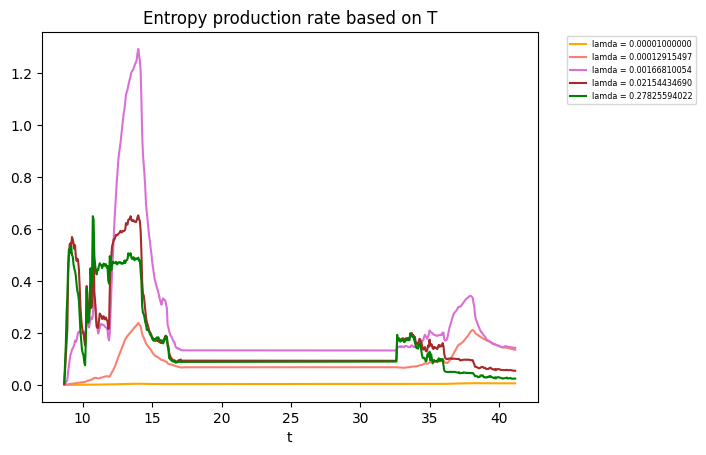

In [22]:
#Plot 5
list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']


for i, lamda in enumerate(selected_lamdas[0:10:2]):
    plt.plot(net_rw.times[sample_times]/3600, S_rate_selected[2*i], color = list_colors[2*i], label='lamda = ' + f'{lamda:.11f}')
    plt.xlabel('t')


plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))

plt.title('Entropy production rate based on T')
#plt.savefig('/home/b/skoove/Desktop/primary_school/S_rate_T.png', format='png', dpi=300)
plt.show()

In [ ]:
fig, axs = plt.subplots(1,2, sharex=False, figsize=(10, 5))

list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']
times_hours_day1 = net_times_hours[0:156]
times_hours_day2 = net_times_hours[156:]

####### Fourth Plot

for i, lamda in enumerate(selected_lamdas):
    axs[0].plot(times_hours_day1, S_rate_selected[i][0:156], color = list_colors[i], label='lamda = ' + f'{lamda:.11f}')


axs[0].set_xlabel('t')
color = 'tab:red'
axs[0].set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
axs[0].tick_params(axis='y', labelcolor=color)
axs[0].text(-0.1,1.1, '(D)', transform=axs[0].transAxes)

list_hours = range(9,18)
ymin = np.min(S_rate_selected)
ymax = np.max(S_rate_selected)

axs[0].vlines(x = list_hours_day1,
            ymin = ymin,
            ymax = ymax,
            linestyles='dotted')

#Plot 5

for i, lamda in enumerate(selected_lamdas):
    axs[1].plot(times_hours_day2, S_rate_selected[i][156:], color = list_colors[i], label='lamda = ' + f'{lamda:.11f}')


axs[1].set_xlabel('t')
color = 'tab:red'
axs[1].set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
axs[1].tick_params(axis='y', labelcolor=color)
#axs[1].text(-0.1,1.1, '(E)', transform=axs[1].transAxes)

list_hours = range(9,18)
ymin = np.min(S_rate_selected)
ymax = np.max(S_rate_selected)

axs[1].vlines(x = list_hours_day2,
            ymin = ymin,
            ymax = ymax,
            linestyles='dotted')

#plt.savefig('/home/b/skoove/Desktop/primary_school/S_rate_T_d1d2.png', format='png', dpi=300)
plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))
fig.suptitle("Entropy production rate based on T: Day 1 and Day 2", fontsize=12)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.subplots_adjust(top=0.88) # # Tight layout requires the title to be spaced accordingly

plt.show()

In [23]:
S_rate_selected_hr = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/primaryschoolnet_rw/S_rate_selected_hr/S_rate{lamda:.11f}', 'rb') as f:
        S_rate = pickle.load(f)
        S_rate_selected_hr.append(S_rate['S_rate'][f'{lamda:.11f}']) #(S[list(S.keys())[0]][0])

In [ ]:
fig, axs = plt.subplots(1,2, sharex=False, figsize=(10, 5))

list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']
times_hours_day1 = net_times_hours_hr[0:1556]
times_hours_day2 = net_times_hours_hr[1556:]

####### Fourth Plot

for i, lamda in enumerate(selected_lamdas[0:10:2]):
    axs[0].plot(times_hours_day1, S_rate_selected_hr[2*i][0:1556], color = list_colors[2*i], label='lamda = ' + f'{lamda:.11f}')


axs[0].set_xlabel('t')
color = 'tab:red'
axs[0].set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
axs[0].tick_params(axis='y', labelcolor=color)
axs[0].text(-0.1,1.1, '(D)', transform=axs[0].transAxes)

list_hours = range(9,18)
ymin = np.min(S_rate_selected_hr)
ymax = np.max(S_rate_selected_hr)

axs[0].vlines(x = list_hours_day1,
            ymin = ymin,
            ymax = ymax,
            linestyles='dotted')


#Plot 5

for i, lamda in enumerate(selected_lamdas[0:10:2]):
    axs[1].plot(times_hours_day2, S_rate_selected_hr[2*i][1556:], color = list_colors[2*i], label='lamda = ' + f'{lamda:.11f}')


axs[1].set_xlabel('t')
color = 'tab:red'
axs[1].set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
axs[1].tick_params(axis='y', labelcolor=color)
#axs[1].text(-0.1,1.1, '(E)', transform=axs[1].transAxes)

list_hours = range(9,18)
ymin = np.min(S_rate_selected_hr)
ymax = np.max(S_rate_selected_hr)

axs[1].vlines(x = list_hours_day2,
            ymin = ymin,
            ymax = ymax,
            linestyles='dotted')

#plt.savefig('/home/b/skoove/Desktop/primary_school/vNS_d1d2.png', format='png', dpi=300)
plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))

fig.suptitle("Entropy production rate based on T_hr: Day 1 and Day 2", fontsize=12)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.subplots_adjust(top=0.88) # # Tight layout requires the title to be spaced accordingly

plt.show()

# Day 1


In [ ]:
fig, axs = plt.subplots(1,1, sharex=False, figsize=(10, 10))

list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']
times_hours_day1 = net_times_hours_hr[0:1556]

####### Fourth Plot

for i, lamda in enumerate(selected_lamdas):
    #if 5 <= i < 10:
    if i == 3:
        normalization = np.max(S_rate_selected_hr[i])
        axs.plot(times_hours_day1, S_rate_selected_hr[i][0:1556], color = list_colors[i], label= r'$\log(\lambda) =$' + f'{np.log10(lamda):.5f}')


#x-axis
axs.set_xlabel('t', fontsize = 14)
tick_positions = [10, 12, 14, 16]
tick_labels = ['10 a.m.', '12 p.m.', '2 p.m.', '4 p.m.']
plt.xticks(tick_positions, tick_labels)
#y-axis
#axs.set_ylabel('Sh')
axs.tick_params(axis='y')


ymin = np.min(S_rate_selected_hr)
ymax = np.max(S_rate_selected_hr)


#plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))

fig.suptitle("Entropy Production Rate for Slow Diffusion Rates: Day 1", fontsize=20)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#fig.subplots_adjust(top=0.88) # # Tight layout requires the title to be spaced accordingly
plt.savefig('/home/b/skoove/Desktop/primary_school/Srate_d1_slow.png', format='png', dpi=600)

plt.show()

In [ ]:
list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']
for i in range(len(selected_lamdas)):

    x = times_hours_day1
    f = S_rate_selected_hr[i][0:1556]

    # Split indices
    x_splits = [240, 600, 960, 1320]

    # Compute integrals
    integrals = auxiliary_functions.segmented_integrals(x, f, x_splits)
    plt.plot(integrals, 'o', color = list_colors[i])

# Instantaneous Rate

In [ ]:
instantaneous_S_rate_selected = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/primaryschoolnet_rw/instantaneous_S_rate_selected/S_rate{lamda:.11f}', 'rb') as f:
        S_rate = pickle.load(f)
        instantaneous_S_rate_selected.append(S_rate['S_rate'][f'{lamda:.11f}'])

In [ ]:
#Plot 5

for i, lamda in enumerate(selected_lamdas[0:4]):
    plt.plot(net_rw.times[sample_times] / 3600, instantaneous_S_rate_selected[i], label='lamda = ' + f'{lamda:.11f}')
    plt.xlabel('t')


plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))
plt.title('Entropy production rate based on  ' + '$\lambda L$')
plt.savefig('/home/b/skoove/Desktop/primary_school/S_rate_lambdaL.png', format='png', dpi=300)
plt.show()

In [ ]:
fig, axs = plt.subplots(1,2, sharex=False, figsize=(10, 5))

list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']
times_hours_day1 = net_times_hours[0:156]
times_hours_day2 = net_times_hours[156:]

####### Fourth Plot

for i, lamda in enumerate(selected_lamdas[0:4]):
    axs[0].plot(times_hours_day1, instantaneous_S_rate_selected[i][0:156], color = list_colors[i], label='lamda = ' + f'{lamda:.11f}')


axs[0].set_xlabel('t')
color = 'tab:red'
axs[0].set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
axs[0].tick_params(axis='y', labelcolor=color)
axs[0].text(-0.1,1.1, '(D)', transform=axs[0].transAxes)

list_hours = range(9,18)
ymin = np.min(instantaneous_S_rate_selected[0:4])
ymax = np.max(instantaneous_S_rate_selected[0:4])

axs[0].vlines(x = list_hours_day1,
            ymin = ymin,
            ymax = ymax,
            linestyles='dotted')


#Plot 5

for i, lamda in enumerate(selected_lamdas[0:4]):
    axs[1].plot(times_hours_day2, instantaneous_S_rate_selected[i][156:], color = list_colors[i], label='lamda = ' + f'{lamda:.11f}')


axs[1].set_xlabel('t')
color = 'tab:red'
axs[1].set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
axs[1].tick_params(axis='y', labelcolor=color)
#axs[1].text(-0.1,1.1, '(E)', transform=axs[1].transAxes)

list_hours = range(9,18)
ymin = np.min(instantaneous_S_rate_selected[0:4])
ymax = np.max(instantaneous_S_rate_selected[0:4])

axs[1].vlines(x = list_hours_day2,
            ymin = ymin,
            ymax = ymax,
            linestyles='dotted')

plt.savefig('/home/b/skoove/Desktop/primary_school/S_rate_lambdaL_d1d2.png', format='png', dpi=300)
plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))
fig.suptitle('Entropy production rate based on ' + '$\lambda L$: Day 1 and Day 2', fontsize=12)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.subplots_adjust(top=0.88) # # Tight layout requires the title to be spaced accordingly
plt.show()

In [ ]:
instantaneous_S_rate_selected_hr = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/primaryschoolnet_rw/instantaneous_S_rate_selected_hr/S_rate{lamda:.11f}', 'rb') as f:
        S_rate = pickle.load(f)
        instantaneous_S_rate_selected_hr.append(S_rate['S_rate'][f'{lamda:.11f}'])

In [ ]:
fig, axs = plt.subplots(1,2, sharex=False, figsize=(10, 5))

list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']
times_hours_day1 = net_times_hours_hr[0:1556]
times_hours_day2 = net_times_hours_hr[1556:]

####### Fourth Plot

for i, lamda in enumerate(selected_lamdas[0:4]):
    axs[0].plot(times_hours_day1, instantaneous_S_rate_selected_hr[i][0:1556], color = list_colors[i], label='lamda = ' + f'{lamda:.11f}')


axs[0].set_xlabel('t')
color = 'tab:red'
axs[0].set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
axs[0].tick_params(axis='y', labelcolor=color)
axs[0].text(-0.1,1.1, '(D)', transform=axs[0].transAxes)

list_hours = range(9,18)
ymin = np.min(instantaneous_S_rate_selected_hr[0:4])
ymax = np.max(instantaneous_S_rate_selected_hr[0:4])

axs[0].vlines(x = list_hours_day1,
            ymin = ymin,
            ymax = ymax,
            linestyles='dotted')


#Plot 5

for i, lamda in enumerate(selected_lamdas[0:4]):
    axs[1].plot(times_hours_day2, instantaneous_S_rate_selected_hr[i][1556:], color = list_colors[i], label='lamda = ' + f'{lamda:.11f}')


axs[1].set_xlabel('t')
color = 'tab:red'
axs[1].set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
axs[1].tick_params(axis='y', labelcolor=color)
#axs[1].text(-0.1,1.1, '(E)', transform=axs[1].transAxes)

list_hours = range(9,18)
ymin = np.min(instantaneous_S_rate_selected_hr[0:4])
ymax = np.max(instantaneous_S_rate_selected_hr[0:4])

axs[1].vlines(x = list_hours_day2,
            ymin = ymin,
            ymax = ymax,
            linestyles='dotted')

#plt.savefig('/home/b/skoove/Desktop/primary_school/vNS_d1d2.png', format='png', dpi=300)
plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))

fig.suptitle('Entropy production rate based on ' + '$\lambda L$_hr: Day 1 and Day 2', fontsize=12)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.subplots_adjust(top=0.88) # # Tight layout requires the title to be spaced accordingly

plt.show()

In [37]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [38]:
N = 40
y = running_mean(instantaneous_S_rate_selected_hr[4][0:1556], N)
plt.plot(times_hours_day1[N-1:], y)

NameError: name 'instantaneous_S_rate_selected_hr' is not defined

ValueError: x and y must have same first dimension, but have shapes (132,) and (1532,)

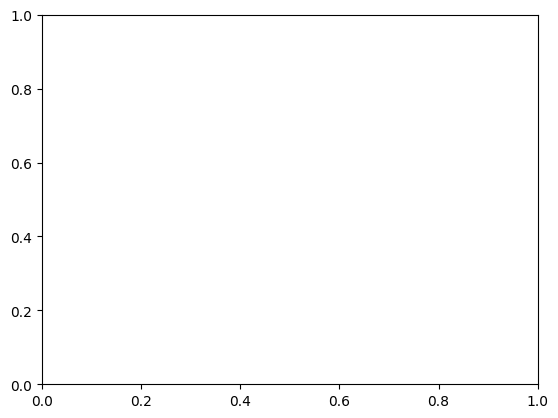

In [39]:
N= 25
y = running_mean(S_rate_selected_hr[8][0:1556], N)
plt.plot(times_hours_day1[N-1:], y)

In [ ]:
L = 
T1 = np.array[[1/2 + np.exp(2)/2, 1/2 - np.exp(2)/2, 0], [1/2 - np.exp(2)/2, 1/2 + np.exp(2)/2, 0], [0, 0, 1]]
print(T1)